# Summary



### Preliminaries

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    pr_filenames = ['MetricSpace_sinbeta_eta1p5']
#     pr_filenames = ['MetricSpace_sinbeta_eta0p5']
#     pr_filenames = ['MetricSpace_sinbeta_eta0p33']
#     pr_filenames = ['MetricSpace_sinbeta_eta0p25']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])
    
# Import Sympy and Numpy and set up latex inline & pretty dict printing
import sympy as sy, numpy as np
sy.init_printing(pretty_print=True,wrap_line=True)
from sympy import Matrix, Eq, lambdify, poly, numer, denom, \
    simplify, factor, expand, cancel, collect, expand_trig, \
    sin,cos,tan,sec, atan, Rational, sqrt, solve, Abs, N, re, im, det, \
    sign, Piecewise, diff
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters
from gmplib.plot_utils import GraphingBase

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.symbols import *
from gme.equations import Equations
# from gme.ode_raytracing import OneRaySolution
from gme.plot import OneRayPlots

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the gme notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from gme package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','Theory')
pr_path, pr_filenames

Deducing working path from gme package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/Theory',
 ['MetricSpace_sinbeta_eta1p5'])

In [2]:
import matplotlib as mpl, matplotlib.pyplot as plt
mpl.rc('font', size=14, family='Arial')

# Theory

## Basics

In [3]:
parameters_dict,_ = import_parameters([pr_path], [os.path.join('..','defaults'), *pr_filenames])
evaluations = {}
evaluations_sequence = ()
pr = Parameters(parameters_dict, evaluations=evaluations, sequence=evaluations_sequence)
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'Theory',
    'short_name': 'metricspace',
    'subtitle': '',
    'title': 'Exploration of metric space for sin(beta) erosion model, eta=3/2',
    'verbose': True,
    'very_verbose': False}
{   'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 3/2,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 3/4,
    't_xiv0_list': None,
    'varepsilon': 1/100,
    'varphi_0': 20,
    'varphi_type': 'ramp',
    'x_1': 1,
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': 30}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {   'Hamilton': 'DOP853',
                  'choices': ['RK45', 'RK23', 'Radau', 'DOP853', 'LSODA'],
                  'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
    't_end': 0.01,
    'vb_res': 101}
{   'do_eliminate_caustics': True,
    'n_isochrones': 3

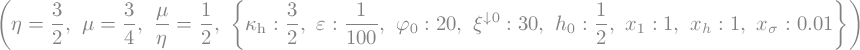

In [4]:
sub = {
        x_1: pr.model.x_1, 
        varepsilon: pr.model.varepsilon, 
        varphi_0: pr.model.varphi_0,
        xiv_0: pr.model.xiv_0,
        kappa_h: pr.model.kappa_h,
        h_0: pr.model.h_0,
        x_sigma: pr.model.x_sigma,
        x_h: pr.model.x_h
}
Eq(eta,pr.model.eta), Eq(mu,pr.model.mu), Eq(mu/eta,pr.model.mu/pr.model.eta), sub

In [5]:
def eqns(eqn_list):
    return [getattr(gmeq, eqn) for eqn in eqn_list]

In [6]:
raw_gmeq = Equations( eta=pr.model.eta, do_raw=True,
                      mu=pr.model.mu, 
                      beta_type=pr.model.beta_type, 
                      varphi_type=pr.model.varphi_type, 
                      ibc_type=pr.model.ibc_type,
                      do_idtx=False,
                      do_geodesic=False, 
                      parameters=sub )

In [7]:
gmeq = Equations( eta=pr.model.eta, 
                  mu=pr.model.mu, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type, 
                  ibc_type=pr.model.ibc_type,
                  do_idtx=False,
                  do_geodesic=False, 
                  parameters=sub )

In [8]:
prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta', gmeq.varphi_type.replace('-','')])

# suffix = f'_eta{float(sy.N(gmeq.eta))}'
suffix = f'_eta{ float(sy.N(gmeq.eta)):0.2f}' if gmeq.eta==Rational(1,3) \
                                    else f'_eta{ float(sy.N(gmeq.eta)):0.1f}'
suffix += f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.2f}' if gmeq.mu/gmeq.eta==Rational(1,3) \
                                    else f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.1f}'
# suffix += f'_xiv{float(sy.N(pr.model.xiv_0)):1.0f}'
suffix = (suffix if pr.model.varphi_type=='ramp' \
            else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}').replace('.','p')

job_name = prefix+suffix
job_name

'metricspace_sinbeta_ramp_eta1p5_ratio0p5'

## Angles

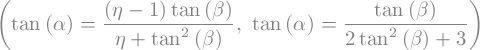

In [9]:
raw_gmeq.tanalpha_beta_eqn, gmeq.tanalpha_beta_eqn

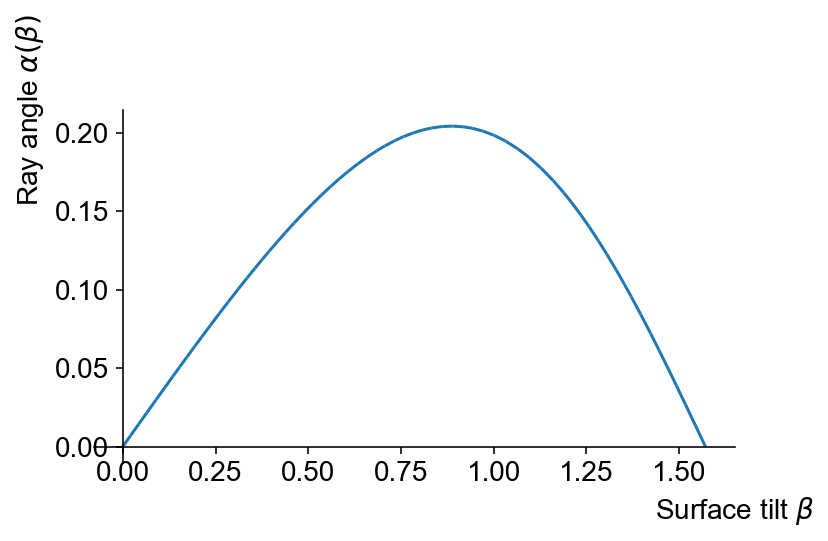

In [10]:
sy.plot(gmeq.tanalpha_beta_eqn.rhs, (beta,0,sy.pi/2), 
        xlabel=r'Surface tilt $\beta$', ylabel=r'Ray angle $\alpha(\beta)$');

In [11]:
raw_gmeq.define_tanbeta_eqns(), gmeq.define_tanbeta_eqns()

(None, None)

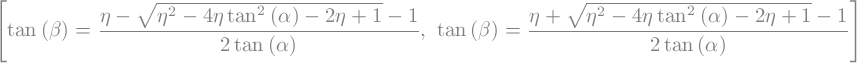

In [12]:
raw_gmeq.tanbeta_alpha_eqns

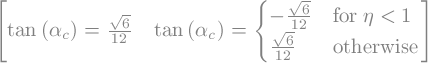

In [13]:
Matrix([raw_gmeq.tanalpha_crit_eqn.subs({eta:pr.model.eta}), gmeq.tanalpha_crit_eqn]).T

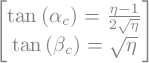

In [14]:
Matrix([raw_gmeq.tanalpha_crit_eqn, raw_gmeq.tanbeta_crit_eqn])

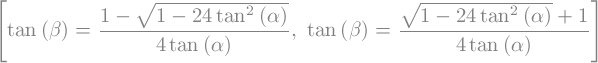

In [15]:
gmeq.tanbeta_alpha_eqns

In [16]:
switch = symbols(r'\text{switch}',  real=True, positive=True)
# tanbeta_tanalpha_piecewise = Piecewise( 
#                                         (gmeq.tanbeta_alpha_eqns[0].rhs, switch<1),
#                                         (gmeq.tanbeta_alpha_eqns[1].rhs, True) 
#                                     )
# tanbeta_tanalpha_lambda = lambdify( (tan(alpha),switch), 
#                                    tanbeta_tanalpha_piecewise, 
#                                    modules='sympy')
# tanbeta_tanalpha_piecewise

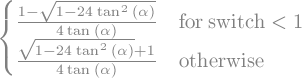

In [17]:
tanbeta_tanalpha_piecewise = Piecewise( 
    (gmeq.tanbeta_alpha_eqns[0].rhs, switch<1),
    (gmeq.tanbeta_alpha_eqns[1].rhs, True) )

tanbeta_tanalpha_lambda = lambdify( (tan(alpha),switch), tanbeta_tanalpha_piecewise, modules='sympy')
tanbeta_tanalpha_piecewise

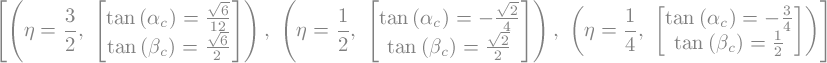

In [18]:
[(Eq(eta,eta_),Matrix([(raw_gmeq.tanalpha_crit_eqns[0] if eta_<1 else raw_gmeq.tanalpha_crit_eqns[1]).subs({eta:eta_}), 
                       (raw_gmeq.tanbeta_crit_eqns[0]  if eta_<1 else raw_gmeq.tanbeta_crit_eqns[1]).subs({eta:eta_})]) )
 for eta_ in [Rational(3,2),Rational(1,2),Rational(1,4)]]

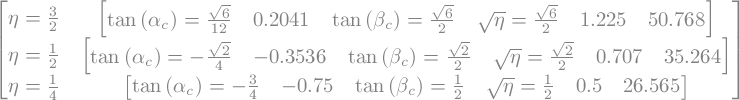

In [19]:
Matrix([(
    Eq(eta,eta_),
    Matrix([
    ([ Matrix([Eq(tan(alpha_crit),soln.subs({eta:eta_})), round(N(soln.subs({eta:eta_})),4)]).T,
        Matrix([
        raw_gmeq.tanbeta_alpha_eqns[0].subs({beta:beta_crit, eta:eta_, 
                                             tan(alpha):soln.subs({eta:eta_})}),
        Eq(sqrt(eta),sqrt(eta_)),
        round(raw_gmeq.tanbeta_alpha_eqns[0].rhs.subs({eta:eta_, tan(alpha):soln.subs({eta:eta_})*1}),3),
        np.round(np.rad2deg(float(N(atan(raw_gmeq.tanbeta_alpha_eqns[0].rhs
                                         .subs({eta:eta_, tan(alpha):soln.subs({eta:eta_})*1}))))),3),
        ]).T
        ]) for soln in [raw_gmeq.tanalpha_crit_eqns[1].rhs 
                        if eta_==Rational(3,2) else raw_gmeq.tanalpha_crit_eqns[0].rhs] ])
) for eta_ in [Rational(3,2),Rational(1,2),Rational(1,4)] ])

In [20]:
# tanalpha_lambda = lambdify( (beta), gmeq.tanalpha_beta_eqn.rhs, modules='sympy' )
# tanbeta_alpha_eqns = [Eq(tan(beta), soln.subs({ta:tan(alpha)}))
#                          for soln in (sy.solve(gmeq.tanalpha_beta_eqn.subs({tan(alpha):ta}),tan(beta)))]
# tanbeta_alpha_eqns

## Metric tensors

In [21]:
unitvec = lambda alpha: N(Matrix([cos(alpha),sin(alpha)]).T)
get_eigenvalues = lambda evs: [ev[0] for ev in evs]
get_eigenvectors = lambda evs: [ev[2][0] for ev in evs]
get_eigentanangles = lambda evs: [ev[2][0][1]/ev[2][0][0] for ev in evs]

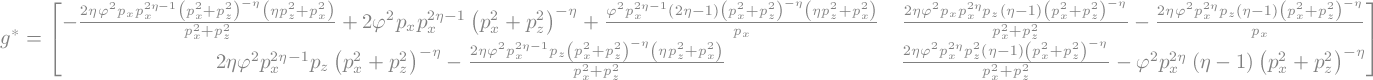

In [22]:
gstar_varphi_pxpz_eqn = Eq(gstar,
    factor( Matrix([diff(raw_gmeq.rdot_vec_eqn.rhs, raw_gmeq.p_covec_eqn.rhs[0]).T,
                    diff(raw_gmeq.rdot_vec_eqn.rhs, raw_gmeq.p_covec_eqn.rhs[1]).T]) ))
gstar_varphi_pxpz_eqn.subs({varphi_r:varphi})

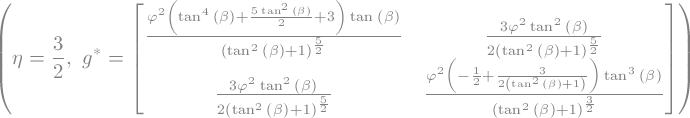

In [23]:
gstar_tanbeta_eqn = (expand_trig(simplify( 
        gstar_varphi_pxpz_eqn
            .subs({varphi_r:varphi})
            .subs(e2d(raw_gmeq.px_pz_tanbeta_eqn))
    )).subs({Abs(cos(beta)):cos(beta)})
    .subs({sin(beta):sqrt(1-cos(beta)**2)})
    .subs({cos(beta):1/sqrt(1+tan(beta)**2)}) )
gstar_tanbeta_eqn
gstar_tanbeta_lambda = lambdify( (tan(beta),varphi), gstar_tanbeta_eqn.rhs.subs({eta:pr.model.eta}), 
                                modules='sympy')
Eq(eta,pr.model.eta), gstar_tanbeta_eqn.subs({eta:pr.model.eta})

In [24]:
Eq(tan(beta_crit),solve(Eq(factor(gstar_tanbeta_eqn.rhs.det()),0),tan(beta))[1])

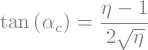

In [25]:
Eq(tan(alpha_crit), solve(raw_gmeq.tanbeta_alpha_eqns[0].subs({tan(beta):sqrt(eta)}),tan(alpha))[0])

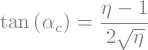

In [26]:
raw_gmeq.tanalpha_crit_eqn

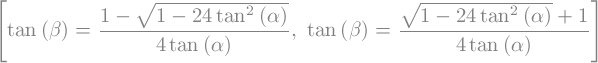

In [27]:
gmeq.tanbeta_alpha_eqns

In [28]:
tanalpha_tanbeta_lambda = lambdify( (tan(beta)), gmeq.tanalpha_beta_eqn.rhs, modules='sympy')

In [29]:
g_tanbeta_eqn = (simplify(factor( gmeq.g_varphi_pxpz_eqn
        .subs({varphi_r:varphi})
        .subs(e2d(gmeq.px_pz_tanbeta_eqn)) ))
        .subs({Abs(cos(beta)):cos(beta)})
        .subs({cos(beta):1/sqrt(1+tan(beta)**2)}) )
g_tanalpha_eqns = [Eq( g, factor(expand_trig(g_tanbeta_eqn.rhs))
                        .subs({cos(beta):1/sqrt(1+tan(beta)**2)})
                        .subs(e2d(tanbeta_alpha_eqn)) )
                  for tanbeta_alpha_eqn in gmeq.tanbeta_alpha_eqns]
# Matrix(g_tanalpha_eqns)

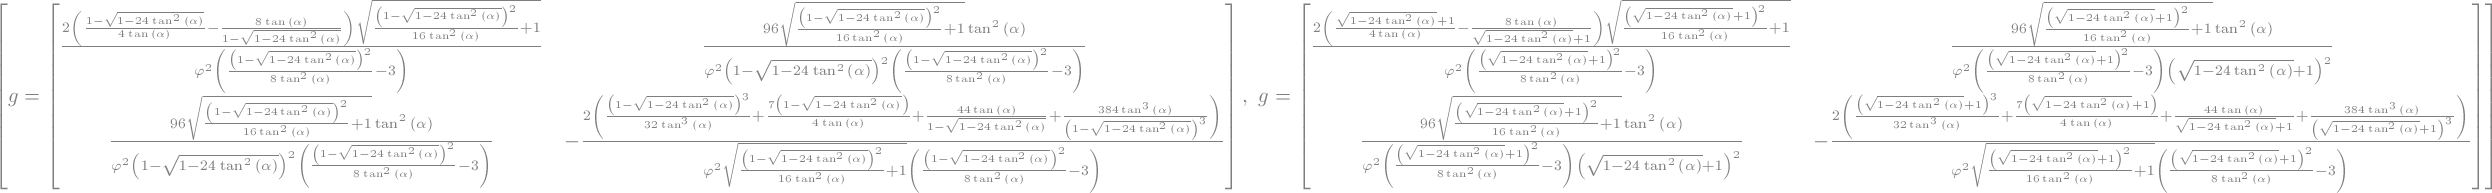

In [30]:
g_tanalpha_eqns

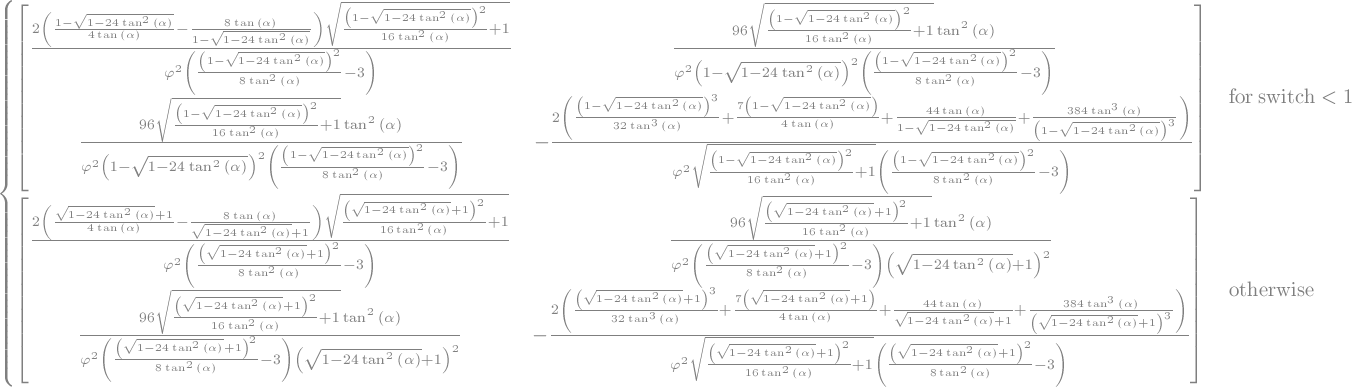

In [31]:
# if gmeq.eta>1:
g_tanalpha_piecewise = Piecewise( 
    (g_tanalpha_eqns[0].rhs, switch<1),
    (g_tanalpha_eqns[1].rhs, True) 
)
# else:
#     g_tanalpha_piecewise = Piecewise( 
#         (g_tanalpha_eqns[0].rhs, switch<1),
#         (g_tanalpha_eqns[1].rhs, True) 
#     )
g_tanalpha_lambda = lambdify( (tan(alpha),varphi,switch), g_tanalpha_piecewise, modules='sympy')
g_tanalpha_piecewise

## Coordinates

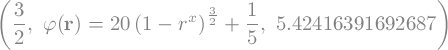

In [74]:
gmeq.eta, gmeq.varphi_rx_eqn.subs(sub).subs({mu:pr.model.mu}), varphi_

In [33]:
tanalpha_crit_ = N(gmeq.tanalpha_crit_eqn.rhs.subs({eta:gmeq.eta}))
tanalpha_ = tanalpha_crit_*0.9
tanbeta_ = tanbeta_tanalpha_lambda(tanalpha_,1)
tanbeta_crit_ = round(tanbeta_tanalpha_lambda(tanalpha_crit_,1),5)
tanalpha_crit_, tanalpha_, tanbeta_crit_, tanbeta_

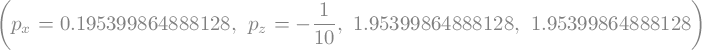

In [34]:
pz_ = (gmeq.pz0_xiv0_eqn.rhs.subs({xiv_0:10}))
px_ = gmeq.px_pz_tanbeta_eqn.rhs.subs({pz:pz_,tan(beta):tanbeta_})
Eq(px,px_), Eq(pz,pz_), -px_/pz_, tanbeta_

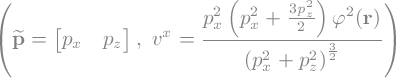

In [35]:
gmeq.p_covec_eqn, gmeq.rdotx_pxpz_eqn

In [36]:
pcovec_lambda = lambdify( (px,pz), 
                          gmeq.p_covec_eqn.rhs.subs({px:px_,pz:pz_}), 
                          modules='sympy' )
pcovec_ = pcovec_lambda(px_,pz_)
Eq(pcovec,pcovec_)

In [37]:
varphi_ = solve(gmeq.pzpx_unity_eqn.subs({px:px_,pz:pz_}),varphi)[0]
varphi_

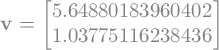

In [38]:
vvec_lambda = lambdify( (px,pz), 
                           Matrix([gmeq.rdotx_pxpz_eqn.rhs.subs({varphi_r:varphi_}),
                                   gmeq.rdotz_pxpz_eqn.rhs.subs({varphi_r:varphi_})]),
                           modules='sympy' )
vvec_ = vvec_lambda(px_,pz_)
Eq(rdotvec,vvec_)

In [39]:
pcovec_.dot(vvec_)

In [40]:
gstar_crit_ = (N(gstar_tanbeta_lambda(tanbeta_tanalpha_lambda(tanalpha_crit_,1),varphi_)))
(Eq(tan(alpha_crit), round(tanalpha_crit_,3)),
 ( det(gstar), 
   round((N(gstar_tanbeta_lambda(tanbeta_tanalpha_lambda(tanalpha_crit_*0.1,0),varphi_))).det(),3),
   round((N(gstar_tanbeta_lambda(tanbeta_tanalpha_lambda(tanalpha_crit_*0.5,0),varphi_))).det(),3),
   round((N(gstar_tanbeta_lambda(tanbeta_tanalpha_lambda(tanalpha_crit_*0.99,0),varphi_))).det(),3),
   round(gstar_crit_.det(),3),
   round((N(gstar_tanbeta_lambda(tanbeta_tanalpha_lambda(tanalpha_crit_*1.01,1),varphi_))).det(),3)))

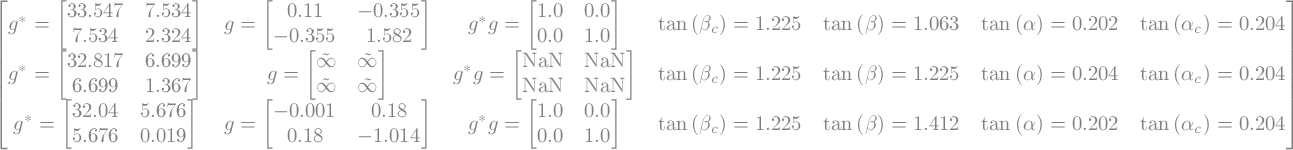

In [41]:
# tanalpha_crit_ = N(gmeq.tanalpha_crit_eqn.rhs.subs({eta:gmeq.eta}))
Matrix([
    (Eq(gstar, (N(gstar_tanbeta_lambda(tanbeta_tanalpha_lambda(tanalpha_,switch_),varphi_)))
                    .applyfunc(lambda x: round(x,3))), 
    Eq(g, (N(g_tanalpha_lambda(tanalpha_,varphi_,switch_)))
                    .applyfunc(lambda x: round(x,3))), 
    Eq(gstar*g, (N(gstar_tanbeta_lambda(tanbeta_tanalpha_lambda(tanalpha_,switch_),varphi_))
                 *N(g_tanalpha_lambda(tanalpha_,varphi_,switch_)))
                    .applyfunc(lambda x: round(x,3))), 
    Eq(tan(beta_crit), round(tanbeta_crit_,3)),
    Eq(tan(beta), round(tanbeta_tanalpha_lambda(tanalpha_,switch_),3)),
    Eq(tan(alpha),round(tanalpha_,3)), Eq(tan(alpha_crit),round(tanalpha_crit_,3)) )
 for tanalpha_,switch_ in zip([tanalpha_crit_*0.99, tanalpha_crit_, tanalpha_crit_*0.99],[0,0,1])])

## Eigenvectors, eigenvalues

In [42]:
g_tanalpha_ = (N(g_tanalpha_lambda(tanalpha_,varphi_,0)))
gstar_tanbeta_ = (N(gstar_tanbeta_lambda(tanbeta_tanalpha_lambda(tanalpha_,0),varphi_)))

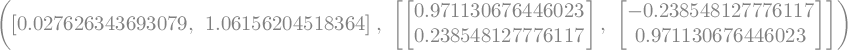

In [43]:
evs = g_tanalpha_.eigenvects()
get_eigenvalues(evs), get_eigenvectors(evs)

In [44]:
(get_eigentanangles(evs), Eq(tan(alpha),tanalpha_))

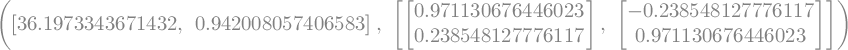

In [45]:
evs = gstar_tanbeta_.eigenvects()
get_eigenvalues(evs), get_eigenvectors(evs)

In [46]:
get_eigentanangles(evs), Eq(tan(beta),tanbeta_)

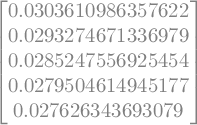

In [47]:
Matrix( [get_eigenvalues((N(g_tanalpha_lambda(tanalpha_*0.80,varphi_,0))).eigenvects())[0],
         get_eigenvalues((N(g_tanalpha_lambda(tanalpha_*0.85,varphi_,0))).eigenvects())[0],
         get_eigenvalues((N(g_tanalpha_lambda(tanalpha_*0.90,varphi_,0))).eigenvects())[0],
         get_eigenvalues((N(g_tanalpha_lambda(tanalpha_*0.95,varphi_,0))).eigenvects())[0],
         get_eigenvalues((N(g_tanalpha_lambda(tanalpha_*1.00,varphi_,0))).eigenvects())[0]] )

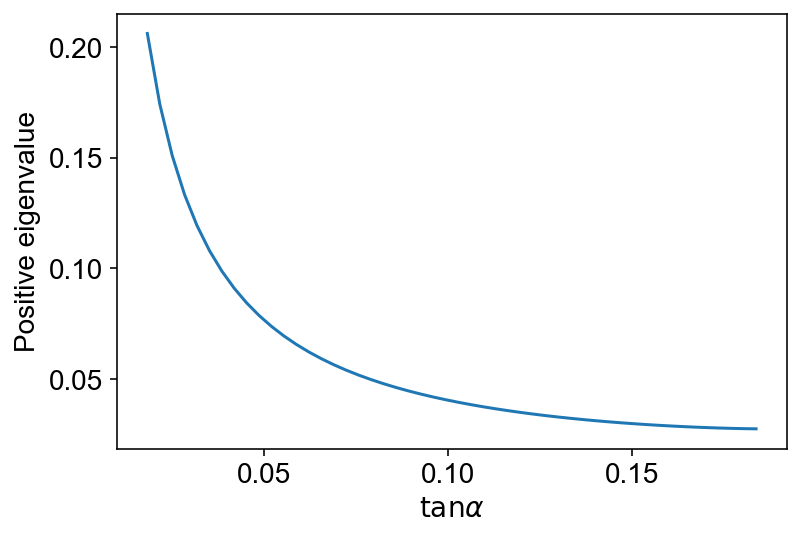

In [48]:
ta_array = np.linspace(0.1,1.0)*tanalpha_
ev_array = np.array( [float(get_eigenvalues((N(g_tanalpha_lambda(ta_,varphi_,0))).eigenvects())[0]) for ta_ in ta_array] )
plt.plot(ta_array,ev_array)
plt.xlabel(r'$\tan\alpha$')
plt.ylabel('Positive eigenvalue');

## Arrays

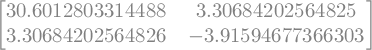

In [49]:
gstar_lambda = lambdify( (px,pz),
                         gmeq.gstar_varphi_pxpz_eqn.rhs.subs({varphi_r:varphi_}),
                         modules='sympy' )
gstar_lambda(px_,pz_)

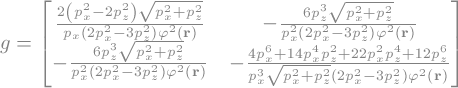

In [50]:
gmeq.g_varphi_pxpz_eqn

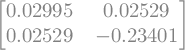

In [51]:
g_lambda = lambdify( (px,pz),
                     gmeq.g_varphi_pxpz_eqn.rhs.subs({varphi_r:varphi_}),
                     modules='sympy' )
g_lambda(px_,pz_).applyfunc(lambda x: round(x,5))

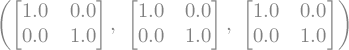

In [52]:
(
    (g_lambda(px_/1.3,pz_)*gstar_lambda(px_/1.3,pz_)).applyfunc(lambda x: round(x,5)),
    (g_lambda(px_*1.0,pz_)*gstar_lambda(px_*1.0,pz_)).applyfunc(lambda x: round(x,5)),
    (g_lambda(px_*1.3,pz_)*gstar_lambda(px_*1.3,pz_)).applyfunc(lambda x: round(x,5))
)

In [53]:
Eq(pcovec,pcovec_), Eq(pcovec,(g_lambda(px_,pz_)*vvec_).T)

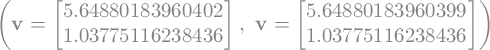

In [54]:
Eq(rdotvec,vvec_), Eq(rdotvec,(pcovec_*gstar_lambda(px_,pz_)).T)

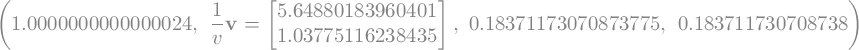

In [55]:
gvv_ = float((vvec_lambda(px_,pz_).T*g_lambda(px_,pz_)*vvec_lambda(px_,pz_))[0])
gvv_, Eq(rdotvec/rdot,vvec_/gvv_), float(vvec_[1]/vvec_[0]), tanalpha_

In [56]:
gstarpp_ = float((pcovec_lambda(px_,pz_)*gstar_lambda(px_,pz_)*pcovec_lambda(px_,pz_).T)[0])
gstarpp_

In [57]:
npx_ = float(px_)
if pr.model.eta == Rational(3,2):
    sfv = 1.2
    px_gvv_array = np.linspace(npx_/sfv,npx_*sfv)
    px_gstarpp_array = np.linspace(npx_/sfv,npx_*sfv)
else:
    sfv = 1.5
    px_gvv_array = np.linspace(npx_/sfv,npx_*sfv)
    px_gstarpp_array = np.linspace(npx_/sfv,npx_*sfv)
    
tanbeta_gvv_array = -px_gvv_array/pz_
tanbeta_gstarpp_array = -px_gstarpp_array/pz_
# These are not "correct" calculations of tan(alpha)...
tanalpha_gvv_array = np.array([tanalpha_tanbeta_lambda(tanbeta__) for tanbeta__ in tanbeta_gvv_array])

vx_array = np.array( [float((vvec_lambda(px__,pz_))[0]) for px__ in px_gvv_array] )
vz_array = np.array( [float((vvec_lambda(px__,pz_))[1]) for px__ in px_gvv_array] )
# ... but these *are* correct
tanalpha_vzvx_array = vz_array/vx_array
tanalpha_gvv_array,tanalpha_vzvx_array;

In [58]:
gvv_array = np.array( 
    [float((vvec_lambda(px__,pz_).T*g_lambda(px__,pz_)*vvec_lambda(px__,pz_))[0]) 
                         for px__ in px_gvv_array] )
vvec_list = [((pcovec_lambda(px__,pz_)*gstar_lambda(px__,pz_)))
                     for px__ in px_gvv_array]
vvec_array = np.stack([
    np.array([float(vvc[0]) for vvc in vvec_list]),
    np.array([float(vvc[1]) for vvc in vvec_list])
]).T
vvec_array[:,1]

array([1.05982767, 1.05770018, 1.05569644, 1.05381408, 1.05205067,
       1.05040371, 1.04887069, 1.04744907, 1.04613629, 1.04492977,
       1.04382693, 1.04282518, 1.04192196, 1.04111469, 1.04040083,
       1.03977784, 1.03924321, 1.03879445, 1.03842911, 1.03814475,
       1.03793898, 1.03780944, 1.03775381, 1.03776979, 1.03785515,
       1.03800766, 1.03822518, 1.03850556, 1.03884673, 1.03924665,
       1.03970333, 1.0402148 , 1.04077917, 1.04139456, 1.04205915,
       1.04277116, 1.04352886, 1.04433056, 1.04517459, 1.04605936,
       1.04698328, 1.04794485, 1.04894256, 1.04997497, 1.05104067,
       1.05213829, 1.0532665 , 1.054424  , 1.05560954, 1.0568219 ])

In [59]:
gstarpp_array = np.array( 
    [float((pcovec_lambda(px__,pz_)*gstar_lambda(px__,pz_)*pcovec_lambda(px__,pz_).T)[0]) 
                         for px__ in px_gstarpp_array] )
pcovec_list = [((g_lambda(px__,pz_)*vvec_lambda(px__,pz_)))
                     for px__ in px_gvv_array]
pcovec_array = np.stack([
    np.array([float(pcvc[0]) for pcvc in pcovec_list]),
    np.array([float(pcvc[1]) for pcvc in pcovec_list])
]).T

In [60]:
(
    pcovec_lambda(px_gvv_array[0],pz_)*vvec_lambda(px_gvv_array[0],pz_),
    pcovec_lambda(px_,pz_)*vvec_lambda(px_,pz_),
    pcovec_lambda(px_gvv_array[-1],pz_)*vvec_lambda(px_gvv_array[-1],pz_),    
)

In [61]:
(
    vvec_lambda(px_gvv_array[0],pz_)[0], 
    (pcovec_lambda(px_gvv_array[0],pz_)*gstar_lambda(px_gvv_array[0],pz_))[0], 
    vvec_array[0,0], vx_array[0]
)

In [62]:
beta_array = np.linspace(0,90)
alpha_array = np.rad2deg(np.arctan(tanalpha_tanbeta_lambda(np.tan(np.deg2rad(beta_array)))))

## Visualizations

In [63]:
gr = GraphingBase()

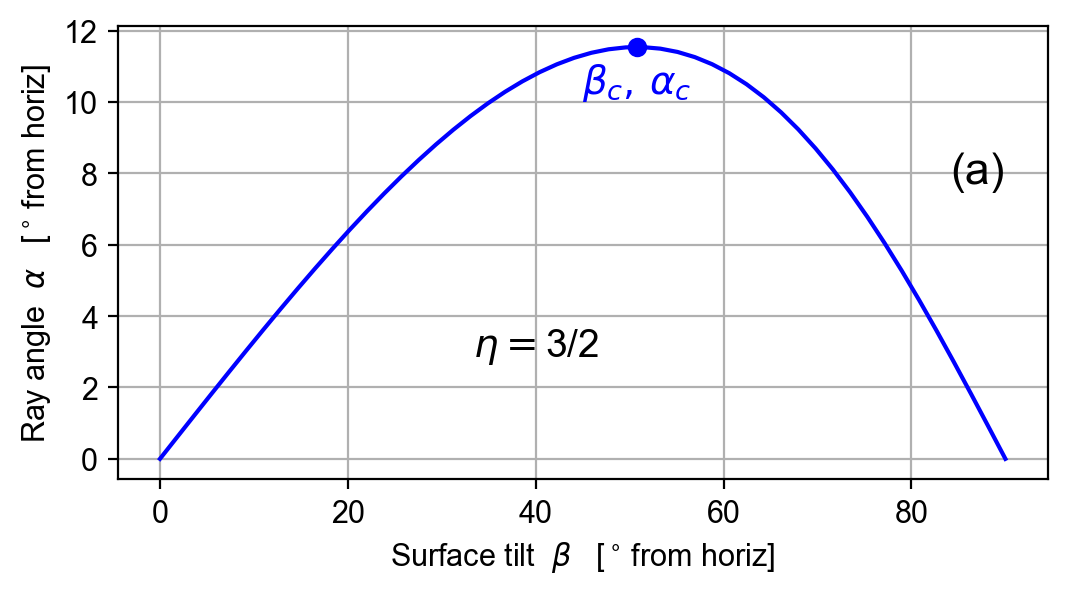

In [64]:
fig = gr.create_figure(job_name+'_alpha_beta', fig_size=(6,3))
plt.plot(beta_array, alpha_array, 'b');
x_,y_ = np.rad2deg(np.arctan(float(tanbeta_crit_))), np.rad2deg(np.arctan(float(tanalpha_crit_)))
plt.plot( x_,y_, 'ob' )
plt.text( x_,y_-y_/9, r'$\beta_c, \,\alpha_c$', color='b', horizontalalignment='center', fontsize=14)
eta_label = fr'$\eta = ${gmeq.eta}'
plt.text( 40,y_/4, fr'$\eta = ${gmeq.eta}', color='k', horizontalalignment='center', fontsize=14)
plt.text( 87,y_*0.67, '(a)' if gmeq.eta==Rational(3,2) else ('(b)' if gmeq.eta==Rational(1,2) else ''),
          color='k', horizontalalignment='center', fontsize=16 )
plt.grid('on')
plt.xlabel(r'Surface tilt  $\beta$   [$^\circ\!$ from horiz]')
plt.ylabel(r'Ray angle  $\alpha$   [$^\circ\!$ from horiz]');
np.rad2deg(np.arctan(float(tanbeta_crit_))), np.rad2deg(np.arctan(float(tanalpha_crit_)));

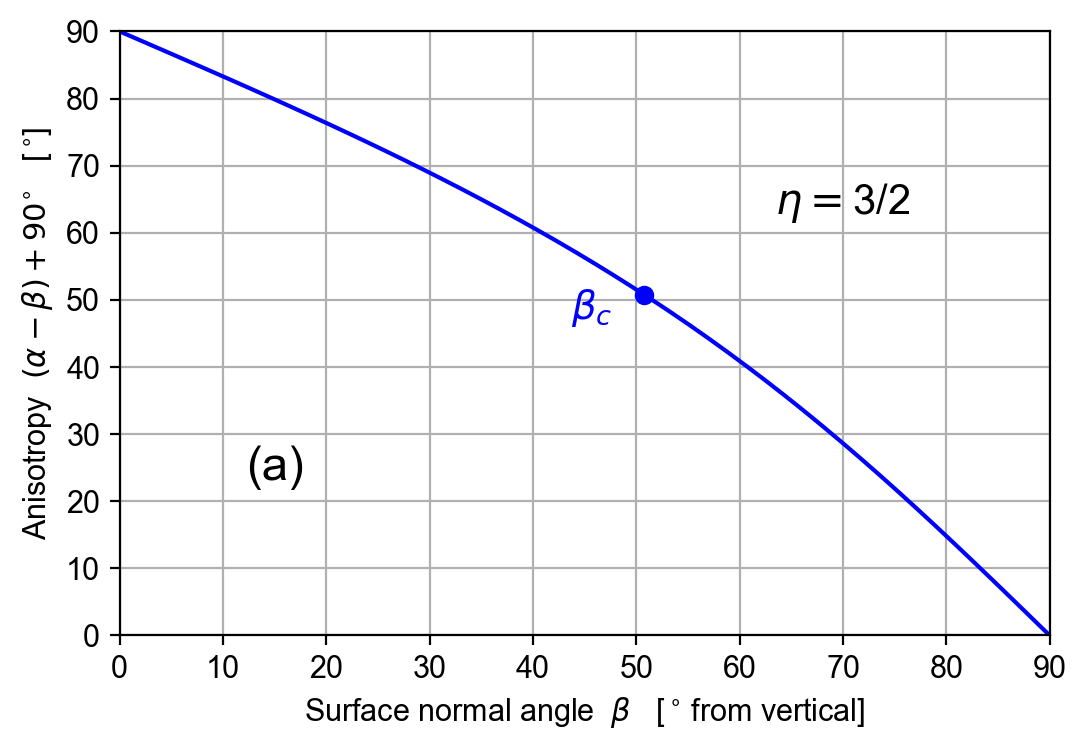

In [65]:
fig = gr.create_figure(job_name+'_anisotropy', fig_size=(6,4))
plt.plot(beta_array, alpha_array-beta_array+90, 'b');
x_,y_ = np.rad2deg(np.arctan(float(tanbeta_crit_))), np.rad2deg(np.arctan(float(tanalpha_crit_)))
plt.plot( x_,y_-x_+90, 'ob' )
if gmeq.eta<1:
    plt.text( x_*(1.2 if gmeq.eta<Rational(1,2) else 1.15),
             (y_-x_+90)*(1.05), r'$\beta_c$', color='b', horizontalalignment='center', fontsize=14)
else:
    plt.text( x_*0.9,(y_-x_+90)*(0.93), r'$\beta_c$', color='b', horizontalalignment='center', fontsize=14)
eta_label = fr'$\eta = ${gmeq.eta}'
plt.text( 70,64.5, fr'$\eta = ${gmeq.eta}', color='k', 
         horizontalalignment='center', verticalalignment='center', fontsize=15)
if gmeq.eta==Rational(3,2):
    plt.text( 15,25, '(a)', color='k', horizontalalignment='center', verticalalignment='center', fontsize=17 )
elif gmeq.eta==Rational(1,2):
    plt.text( 15,25, '(b)', color='k', horizontalalignment='center', verticalalignment='center', fontsize=17 )
plt.grid('on')
plt.xlabel(r'Surface normal angle  $\beta$   [$^\circ\!$ from vertical]')
plt.ylabel(r'Anisotropy  $(\alpha-\beta)+90^{\circ}$   [$^\circ\!$]');
np.rad2deg(np.arctan(float(tanbeta_crit_))), np.rad2deg(np.arctan(float(tanalpha_crit_)));
plt.xlim(0,90)
plt.ylim(0,90);

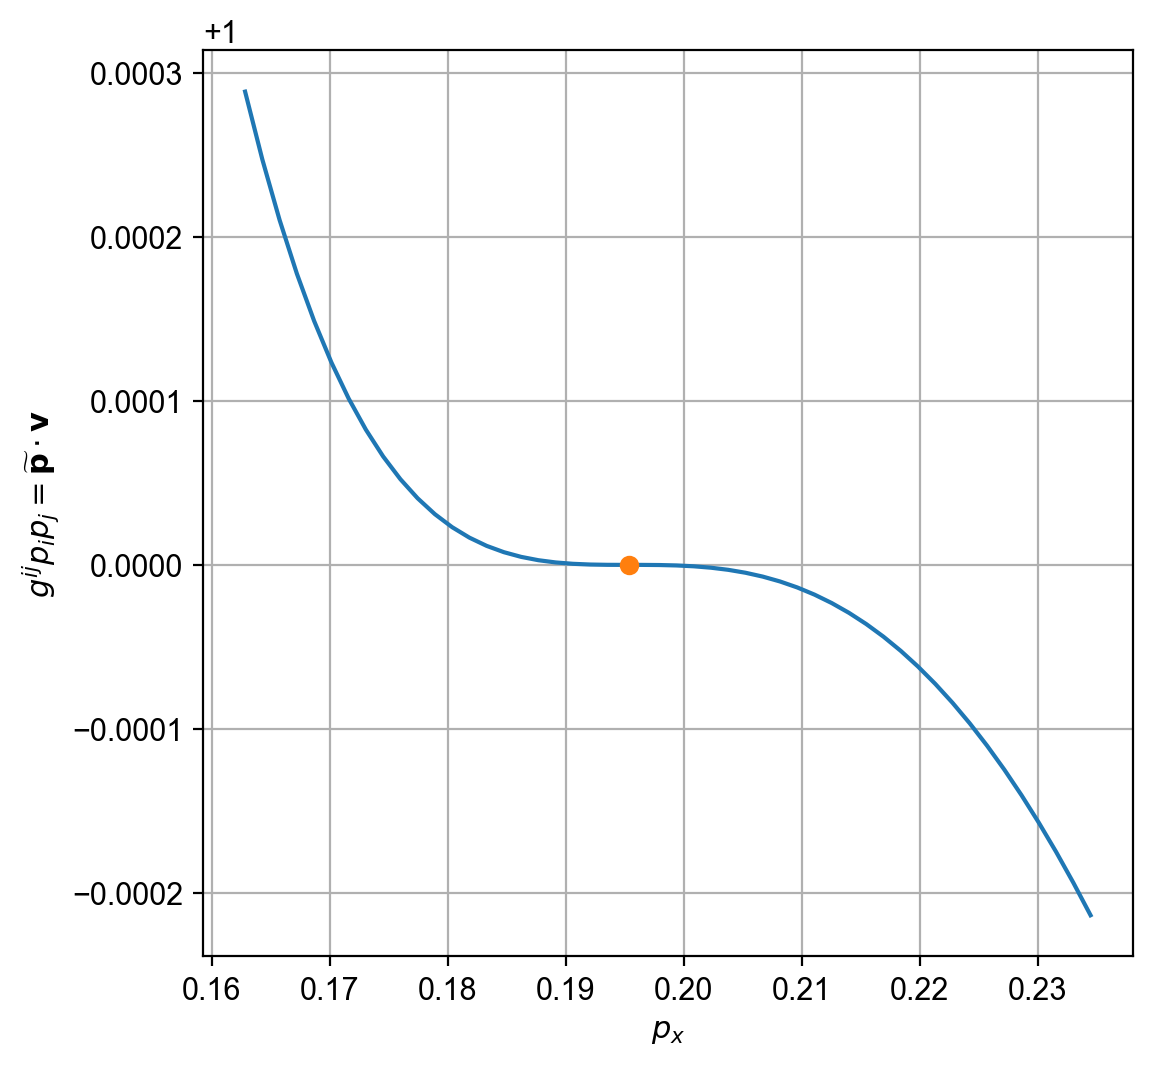

In [66]:
fig = gr.create_figure(job_name+'_pdotv_px', fig_size=(6,6))
plt.plot(px_gstarpp_array, gstarpp_array)
plt.plot(px_, gstarpp_, 'o')
plt.grid('on')
plt.ylabel(r'$g^{ij} p_i p_j = \mathbf{\widetilde{p}}\cdot\mathbf{v}$')
plt.xlabel(r'$p_x$');

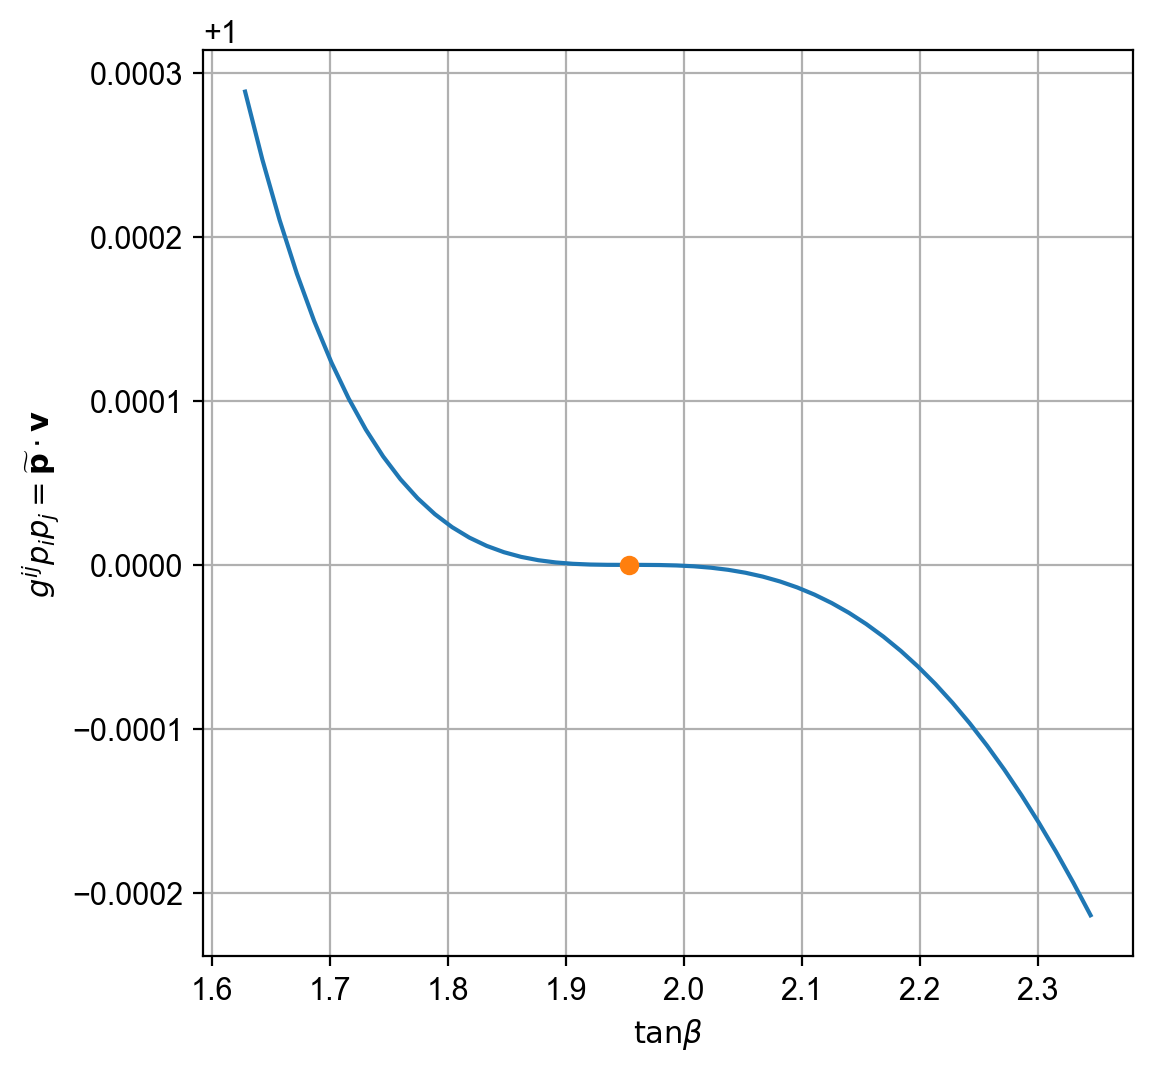

In [67]:
fig = gr.create_figure(job_name+'_pdotv_tanbeta', fig_size=(6,6))
plt.plot(tanbeta_gstarpp_array, gstarpp_array)
plt.plot(-px_/pz_, gstarpp_, 'o')
plt.grid('on')
plt.ylabel(r'$g^{ij} p_i p_j = \mathbf{\widetilde{p}}\cdot\mathbf{v}$')
plt.xlabel(r'$\tan\beta$');

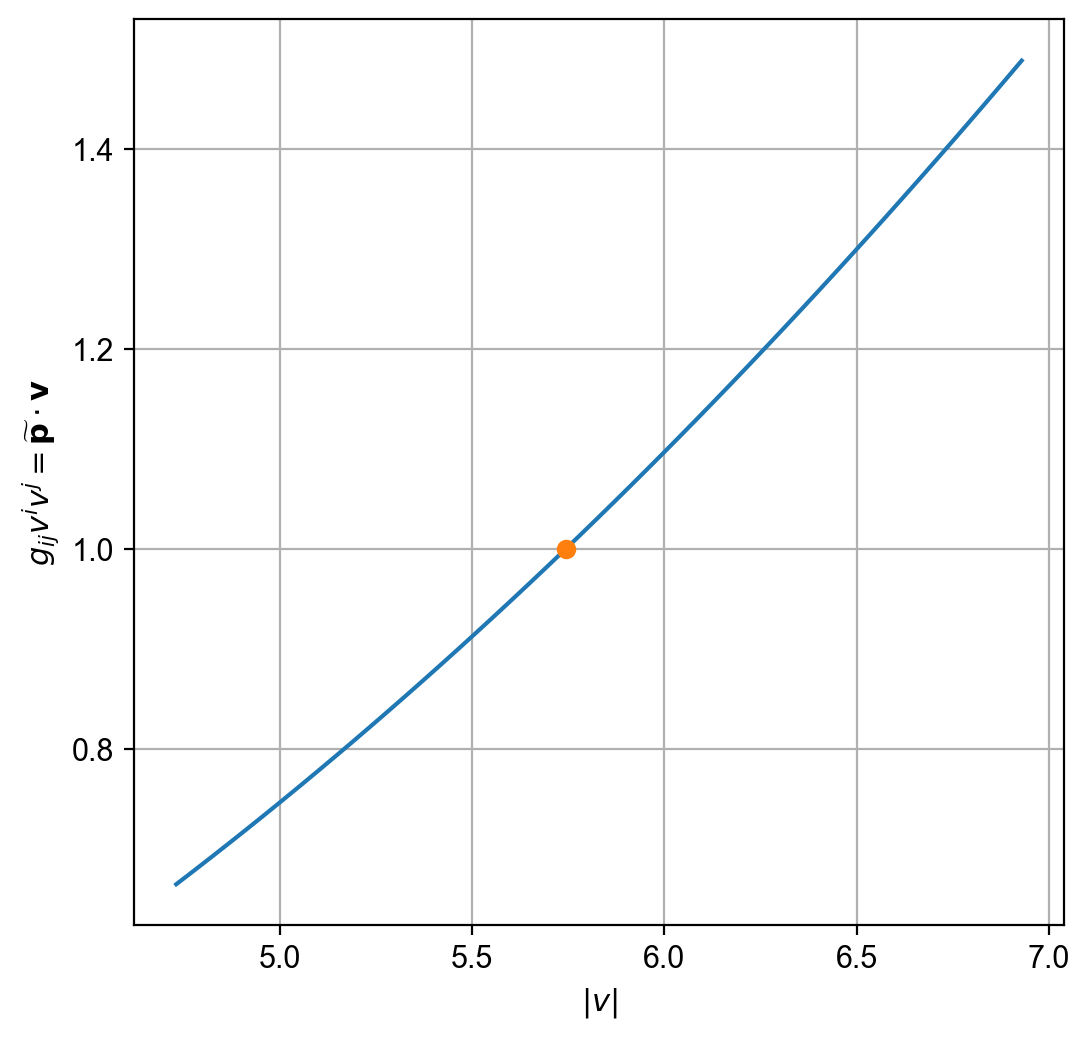

In [68]:
fig = gr.create_figure(job_name+'_pdotv_modv', fig_size=(6,6))
plt.plot(np.sqrt(vx_array**2+vz_array**2), gvv_array)
vvec_ = vvec_lambda(px_,pz_)
plt.plot(np.sqrt(float(vvec_[0])**2+float(vvec_[1])**2), gvv_, 'o')
plt.grid('on')
plt.ylabel(r'$g_{ij} v^i v^j = \mathbf{\widetilde{p}}\cdot\mathbf{v}$')
plt.xlabel(r'$|v|$');

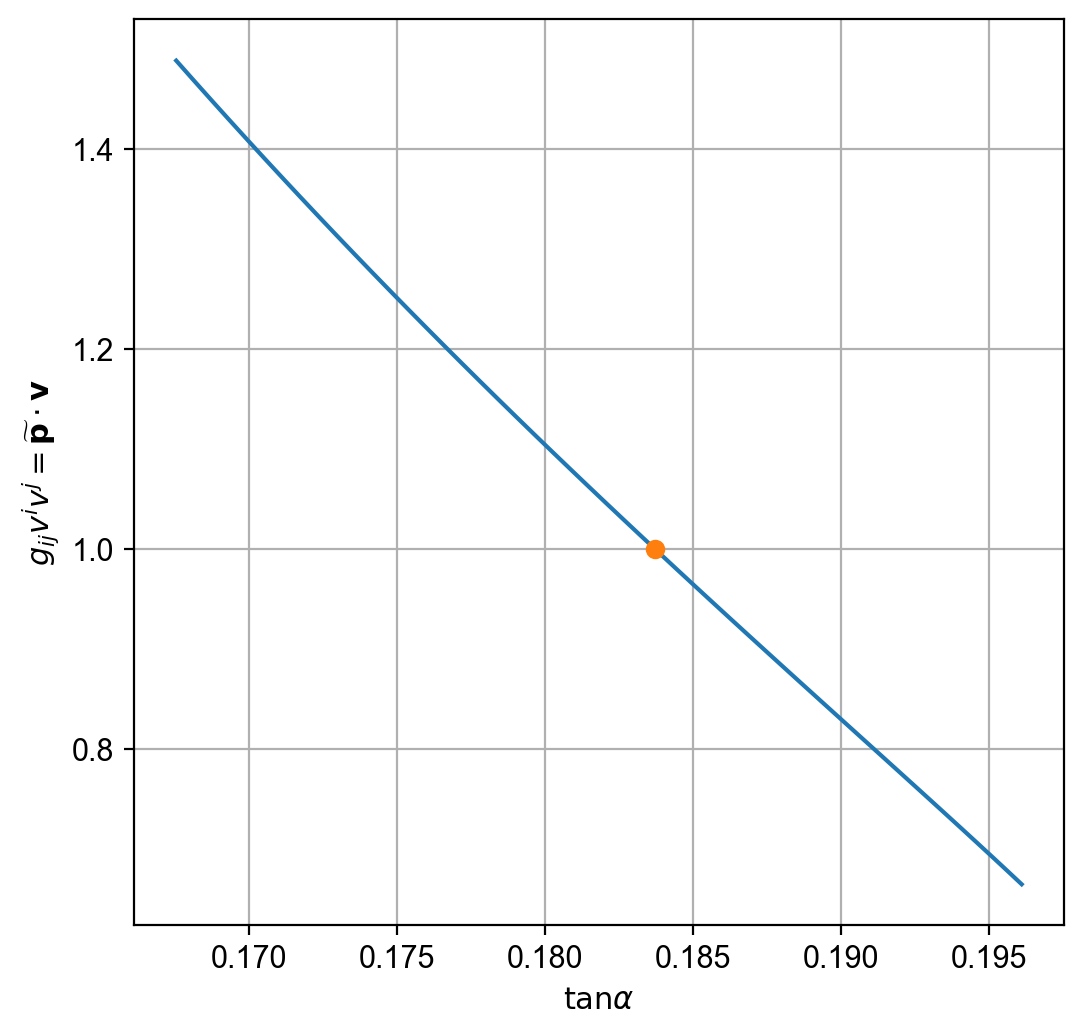

In [69]:
fig = gr.create_figure(job_name+'_pdotv_tanalpha', fig_size=(6,6))
plt.plot(tanalpha_vzvx_array, gvv_array)
plt.plot(tanalpha_, gvv_, 'o')
plt.grid('on')
plt.ylabel(r'$g_{ij} v^i v^j = \mathbf{\widetilde{p}}\cdot\mathbf{v}$')
plt.xlabel(r'$\tan\alpha$');

# Save

Export the graphs as PNG and/or PDF image files.

In [70]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' )

Writing to dir: "/Users/colinstark/Projects/GME/Plots/Theory"
Exported "metricspace_sinbeta_ramp_eta1p5_ratio0p5_alpha_beta.png"
Exported "metricspace_sinbeta_ramp_eta1p5_ratio0p5_anisotropy.png"
Exported "metricspace_sinbeta_ramp_eta1p5_ratio0p5_pdotv_px.png"
Exported "metricspace_sinbeta_ramp_eta1p5_ratio0p5_pdotv_tanbeta.png"
Exported "metricspace_sinbeta_ramp_eta1p5_ratio0p5_pdotv_modv.png"
Exported "metricspace_sinbeta_ramp_eta1p5_ratio0p5_pdotv_tanalpha.png"
